In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data():
    data = sio.loadmat("../dataset/KO_train.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [3]:
def ode_fn(t, u, a, b):
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t = tf.gradients(u1, t)[0]
    u2_t = tf.gradients(u2, t)[0]
    u3_t = tf.gradients(u3, t)[0]

    f1 = u1_t - a * u2 * u3
    f2 = u2_t - b * u1 * u3
    f3 = u3_t + (a + b) * u1 * u2
    return tf.concat([f1, f2, f3], axis=-1)

In [4]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:3], u_train[:3, 1:2]
    
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=2),
    )
    
    # build likelihood
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=1000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=666,
    )
    model.compile(method)
    
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_a, process_b]
    return processes, samples, model

In [5]:
@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]
    
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    # build losses
    loss_u13 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        multiplier=1.0,
    )
    loss_u2 = neuq.likelihoods.MSE(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        multiplier=1.0,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[loss_u13, loss_u2, loss_f],
    )
    
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    
    # method = neuq.inferences.SEns(num_samples=20, num_iterations=20000)
    model.compile(method)
    
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_a, process_b]
    return processes, samples, model

In [6]:
@neuq.utils.timer
def Variational(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:], u_train[:, 1:2]
    
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
        posterior=neuq_vars.fnn.Variational(
            layers=layers, mean=0, sigma=0.01, trainable=True
        ),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    
    # build likelihoods
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    
    # assign and compile method
    method = neuq.inferences.VI(
        batch_size=64,
        num_samples=1000,
        num_iterations=20000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_a, process_b]
    return processes, samples, model

In [7]:
@neuq.utils.timer
def MCD(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:], u_train[:, 1:2]
    
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
        posterior=neuq_vars.fnn.MCD(layers=layers, dropout_rate=0.01, trainable=True),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    
    # build likelihoods
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    
    # assign and compile method
    method = neuq.inferences.VI(
        batch_size=64,
        num_samples=1000,
        num_iterations=20000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    
    # obtain posterior samples
    samples = model.run()
    
    processes = [process_u, process_a, process_b]
    return processes, samples, model

In [8]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:3], u_train[:3, 1:2]  # training data

    neuq.utils.hist(a_pred, name="value of $a$")
    neuq.utils.hist(b_pred, name="value of $b$")
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )

In [9]:
################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

In [10]:
# Build model and perform inference ########################
    # All models share the same general procedure:
    # Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
    # Step 2: build prior and/or posterior using [variables]
    # Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
    # Step 4: build likelihood, given noisy measurements, using [likelihoods]
    # Step 5: build model using [models]
    # Step 6: create an inference method and assign it to the model using [inferences]
    # Step 7: perform posterior sampling using [model.run]

In [11]:
    ############################### Choose framework #################################
    processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.403 

Execution time for 'Samplable' function is: 480.823 s, 8.014 mins


In [12]:
################################# Predictions ####################################
u_pred, a_pred, b_pred = model.predict(t_test, samples, processes, pde_fn=None)

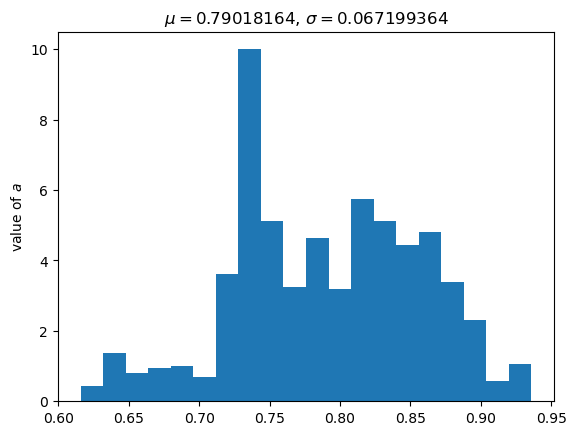

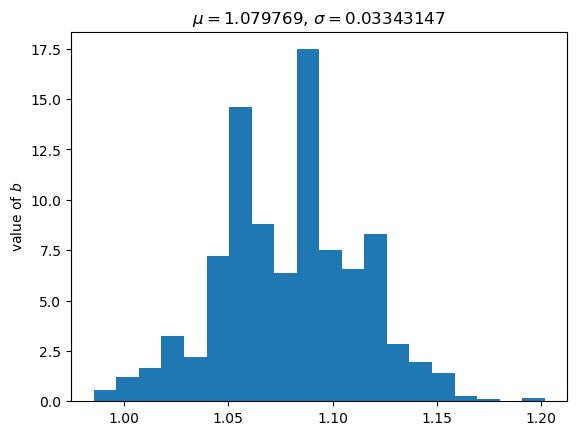

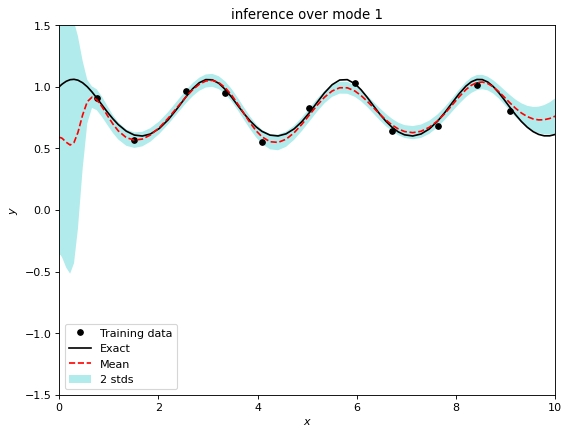

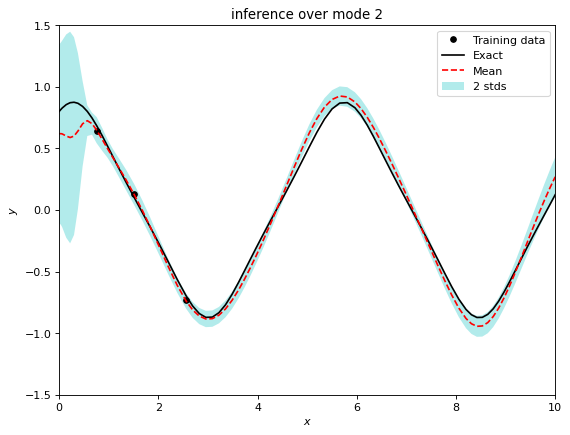

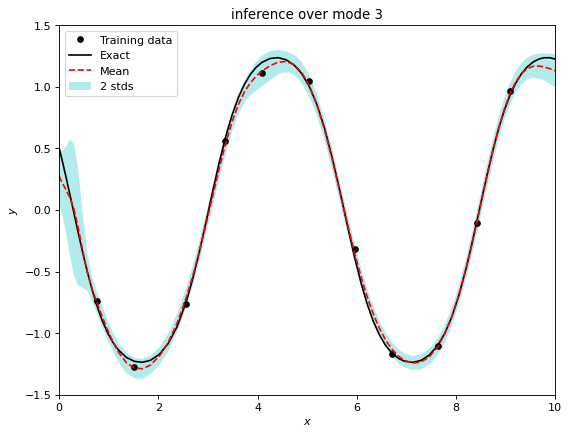

In [13]:
############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)